## Analyzing Meteorite Landings Across the World  
This project will analyze documented meteorite landings and attempt to find patterns in the locations found.  

https://github.com/carl-schick-ds/meteorite-landings

***
### Setup
Import needed libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [11]:
# Import Libraries

import pandas as pd
import numpy as np
import datetime

***
### Data Collection
The first step of the project is to collect the data from various sources on the internet.  

Data is currently collected from three main sources...
 - NASA's Open Data Portal (data.nasa.gov)
    - Specifically, meteorite landings are available via the Socrata Open Data API at https://dev.socrata.com/foundry/data.nasa.gov/gh4g-9sfh
 - The U.S. Census Bureau (www.census.gov)
    - Specifically, the 2020 estimated U.S. population, by county, was retrieved from https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/
    - The csv dataset 'co-est2020.csv' was downloaded from this address and is avaiable as part of the git repository.
 - Github public gists (gist.github.com)
    - Specifically, a public dataset cross-referencing 2-char country codes to 3-char country codes and country names was obtained from https://gist.github.com/tadast/8827699
    - The csv dataset 'countries_codes_and_coordinates.csv' was downloaded from this address and is avaiable as part of the git repository.

NASA data on meteorite landings was collected in advance and is stored in 'meteorite-landings.csv' as part of the git repository.
Optionally, the NASA data can be refreshed from the open data portal by following these instructions...
 - Change the REFRESH_DATA literal to True.
 - Obtain a NASA Open Data Portal App Token from https://data.nasa.gov/profile/edit/developer_settings.
 - Add a ".env" file to this directory with a single line: APP_TOKEN = [Your App Token].

In [12]:
# Toggle REFRESH_DATA literal

REFRESH_DATA = False

In [13]:
# Refresh Data

if REFRESH_DATA:
    import data_collection as dc

    # Get the data
    meteorite_data = dc.get_meteorite_data()
    print("")
    meteorite_data = dc.process_locations(meteorite_data)
    print("")
    meteorite_data = dc.get_country_data(meteorite_data)

    # Convert to CSV file
    meteorite_data.to_csv('meteorite-landings.csv')

Queried NASA for all meteorite landings.
Found and collected 45716 entries.

Dropped 7315 missing locations.
Dropped 1 invalid locations.
Total valid entries:  38400

Added country data to the dataset.


***
### Data Loading and Cleaning

#### Load CSVs
Load the data from the csv files and run a quick review of the data for validity checks

In [96]:
meteorite_data = pd.read_csv('meteorite-landings.csv', index_col=0)
population_data = pd.read_csv('co-est2020.csv', encoding = 'ISO-8859-1')
population_data = population_data[population_data['SUMLEV'] == 50]
population_data = population_data[['STNAME', 'CTYNAME', 'POPESTIMATE2020']]
population_data.rename(columns={'STNAME': 'state', 'CTYNAME': 'county', 'POPESTIMATE2020': 'population'}, inplace=True)
display(meteorite_data.head(10))
display(population_data.head(10))

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
0,Aachen,1,Valid,L5,21.0,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,Germany,DE,DEU,North Rhine-Westphalia,Regierungsbezirk Koln
1,Aarhus,2,Valid,H6,720.0,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,Denmark,DK,DNK,Central Jutland,Arhus Kommune
2,Abee,6,Valid,EH4,107000.0,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,Canada,CA,CAN,Alberta,NaN
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,Mexico,MX,MEX,Guerrero,NaN
4,Achiras,370,Valid,L6,780.0,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,Argentina,AR,ARG,Cordoba,NaN
5,Adhi Kot,379,Valid,EH4,4239.0,Fell,1919-01-01T00:00:00.000,32.10000,71.80000,Pakistan,PK,PAK,Punjab,NaN
6,Adzhi-Bogdo (stone),390,Valid,LL3-6,910.0,Fell,1949-01-01T00:00:00.000,44.83333,95.16667,Mongolia,MN,MNG,Govi-Altay,NaN
7,Agen,392,Valid,H5,30000.0,Fell,1814-01-01T00:00:00.000,44.21667,0.61667,France,FR,FRA,Aquitaine,Departement du Lot-et-Garonne
8,Aguada,398,Valid,L6,1620.0,Fell,1930-01-01T00:00:00.000,-31.60000,-65.23333,Argentina,AR,ARG,Cordoba,NaN
9,Aguila Blanca,417,Valid,L,1440.0,Fell,1920-01-01T00:00:00.000,-30.86667,-64.55000,Argentina,AR,ARG,Cordoba,NaN


,state,county,population
1,Alabama,Autauga County,56145
2,Alabama,Baldwin County,229287
3,Alabama,Barbour County,24589
4,Alabama,Bibb County,22136
5,Alabama,Blount County,57879
6,Alabama,Bullock County,9976
7,Alabama,Butler County,19504
8,Alabama,Calhoun County,113469
9,Alabama,Chambers County,32865
10,Alabama,Cherokee County,26294


In [97]:
# Quick review of Meteorite data
print(meteorite_data.shape)
print(meteorite_data.info())
print(meteorite_data.isna().sum())

(38400, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38400 entries, 0 to 45715
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            38400 non-null  object 
 1   id              38400 non-null  int64  
 2   nametype        38400 non-null  object 
 3   recclass        38400 non-null  object 
 4   mass            38282 non-null  float64
 5   fall            38400 non-null  object 
 6   year            38222 non-null  object 
 7   reclat          38400 non-null  float64
 8   reclong         38400 non-null  float64
 9   country_name    38400 non-null  object 
 10  country_code_2  38379 non-null  object 
 11  country_code_3  38400 non-null  object 
 12  admin1          26461 non-null  object 
 13  admin2          9706 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 4.4+ MB
None
name                  0
id                    0
nametype              0
recclass           

####  Clean Types
Clean up some data types and columns

In [98]:
# The id column looks like a good choice for an index.  Let's make sure it's unique.
print('Rows: ', meteorite_data.shape[0])
print('Unique ids: ', meteorite_data['id'].nunique())

# Looks good.  Let's make id the index.
meteorite_data.set_index('id', inplace=True)
meteorite_data.head()

Rows:  38400
Unique ids:  38400


,name,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
id,,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,Germany,DE,DEU,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,Denmark,DK,DNK,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,Canada,CA,CAN,Alberta,NaN
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,Mexico,MX,MEX,Guerrero,NaN
370,Achiras,Valid,L6,780.0,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,Argentina,AR,ARG,Cordoba,NaN


In [99]:
# The year is a string that is formateted as a date time.  We will just extract the year as the first four characters.
# First let's see if any values will be hard to deal with
print(meteorite_data['year'].isna().sum())  ## There are 178 NaN values we will need to handle

# Confirming the month, day, time is always Jan 1, midnight, and we can just strip the year
# print(meteorite_data['year'].str[4:].nunique())
# meteorite_data['year'] = meteorite_data['year'].str[0:4]

# Alternatively, we can converte to datetime and grab the year
meteorite_data['year'] = meteorite_data['year'].apply(lambda x: datetime.datetime.fromisoformat(x).year if pd.notna(x) else np.nan)
meteorite_data['year'] = meteorite_data['year'].astype('Int64')
meteorite_data.head()

178


,name,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
id,,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880,50.77500,6.08333,Germany,DE,DEU,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951,56.18333,10.23333,Denmark,DK,DNK,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,Canada,CA,CAN,Alberta,NaN
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,Mexico,MX,MEX,Guerrero,NaN
370,Achiras,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,Argentina,AR,ARG,Cordoba,NaN


Categorical data for this dataset is defined as follows:
 - nametype
   - Relict: objects that were once meteorites (meteoritic origin) but are now highly altered by weathering on Earth (dominantly composed of secondary minerals)
   - Valid: all other meteorites
 - recclass
   - See: https://craterexplorer.ca/meteorite-glossary/
 - fall
   - Fell: the delivery of a meteorite to Earth was witnessed, either by humans or their devices
   - Found: all other meteorites

In [100]:
# It looks like nametype, recclass, and fall are categories.  Let's check the values.
print(meteorite_data['nametype'].value_counts())
# print(meteorite_data['recclass'].value_counts())
print(meteorite_data['fall'].value_counts())

# Each is confirmed to be categorical.  We will update the dtypes.
meteorite_data['nametype'] = meteorite_data['nametype'].astype('category')
meteorite_data['recclass'] = meteorite_data['recclass'].astype('category')
meteorite_data['fall'] = meteorite_data['fall'].astype('category')
print(meteorite_data.info())


Valid     38330
Relict       70
Name: nametype, dtype: int64
Found    37303
Fell      1097
Name: fall, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38400 entries, 1 to 30414
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            38400 non-null  object  
 1   nametype        38400 non-null  category
 2   recclass        38400 non-null  category
 3   mass            38282 non-null  float64 
 4   fall            38400 non-null  category
 5   year            38222 non-null  Int64   
 6   reclat          38400 non-null  float64 
 7   reclong         38400 non-null  float64 
 8   country_name    38400 non-null  object  
 9   country_code_2  38379 non-null  object  
 10  country_code_3  38400 non-null  object  
 11  admin1          26461 non-null  object  
 12  admin2          9706 non-null   object  
dtypes: Int64(1), category(3), float64(3), object(6)
memory usage: 3.4+ MB
None


In [101]:
meteorite_data['country_name'] = meteorite_data['country_name'].fillna('')
meteorite_data['country_code_2'] = meteorite_data['country_code_2'].fillna('')
meteorite_data['country_code_3'] = meteorite_data['country_code_3'].fillna('')
meteorite_data['admin1'] = meteorite_data['admin1'].fillna('')
meteorite_data['admin2'] = meteorite_data['admin2'].fillna('')

***
### Data Exploration

In [102]:
meteorite_data.head()

,name,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
id,,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880,50.77500,6.08333,Germany,DE,DEU,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951,56.18333,10.23333,Denmark,DK,DNK,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,Canada,CA,CAN,Alberta,
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,Mexico,MX,MEX,Guerrero,
370,Achiras,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,Argentina,AR,ARG,Cordoba,


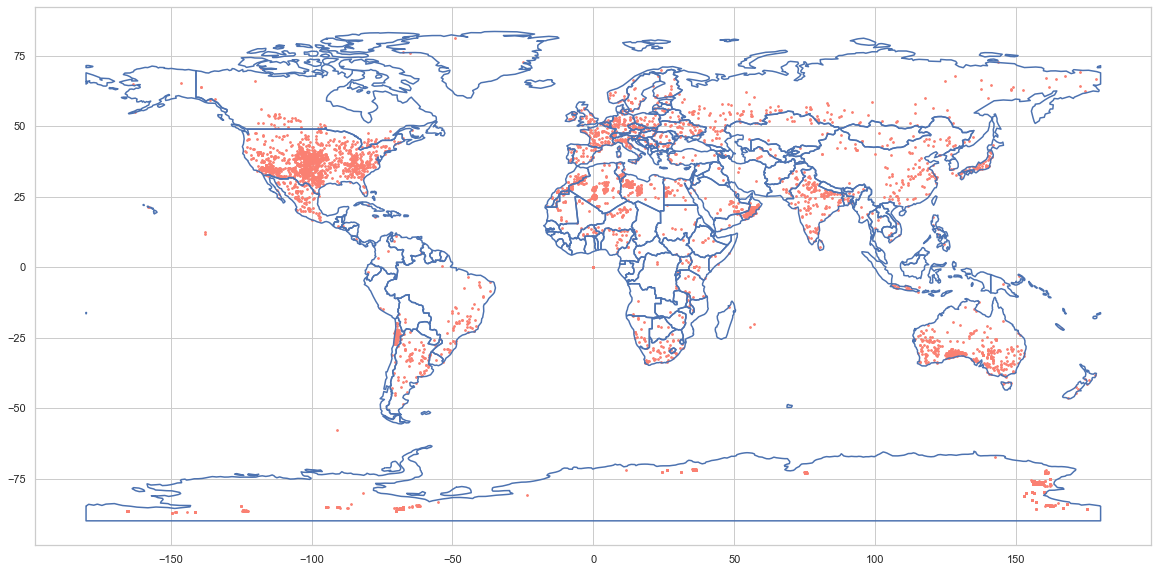

In [103]:
# Import visualization libraries
# pip install shapely
# pip install geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from IPython.display import display

geometry = [Point(xy) for xy in zip(meteorite_data['reclong'], meteorite_data['reclat'])]
gdf = GeoDataFrame(meteorite_data, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.boundary.plot(figsize=(20, 12)), marker='o', color='salmon', markersize=3);


Text(0, 0.5, 'CountryÇ')

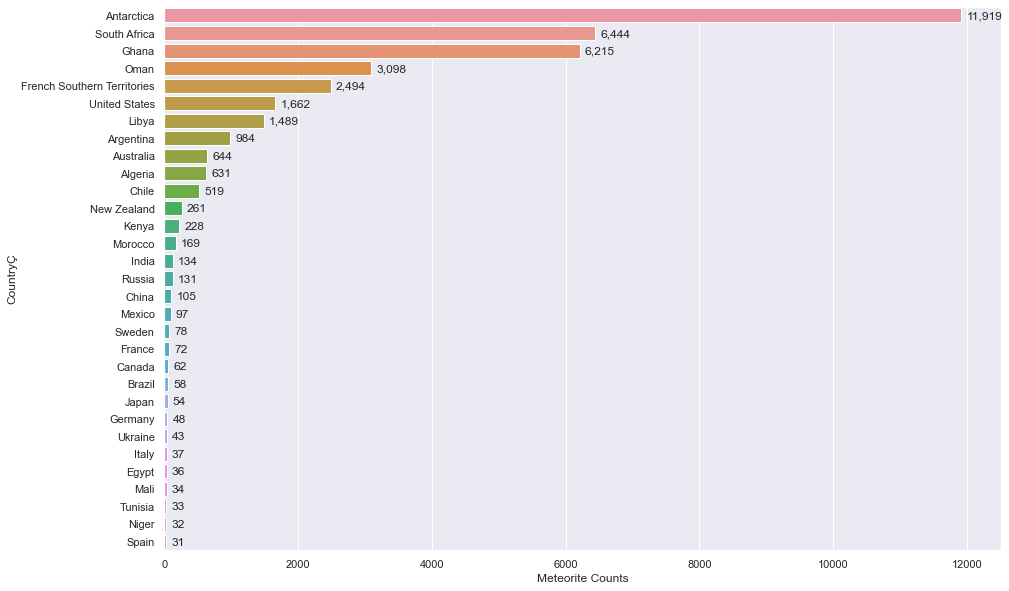

In [104]:
sns.set(rc={"figure.figsize":(15, 10)})
meteorite_counts = pd.DataFrame(meteorite_data.groupby(['country_name']).size().reset_index(name='meteorite_count'))
meteorite_counts.sort_values(by='meteorite_count', ascending=False, inplace=True)
# print(meteorite_counts['meteorite_count'].value_counts())

mask = meteorite_counts['meteorite_count'] > 25
g = sns.barplot(data=meteorite_counts[mask], x='meteorite_count', y='country_name')

for p in g.patches:
    pass
    _x = p.get_x() + p.get_width() + float(75)
    _y = p.get_y() + p.get_height() - (p.get_height()*0.25)
    value = '{:,.0f}'.format(p.get_width())
    # value = '{:.1f}'.format(p.get_width())
    g.text(_x, _y, value, ha="left")

g.set_xlabel('Meteorite Counts')
g.set_ylabel('CountryÇ')
# print(meteorite_counts)


In [105]:
mask = (meteorite_data['country_name'] == 'United States')
# mask = (meteorite_data['country_name'] == 'United States') & (meteorite_data['fall'] == 'Fell')
meteorite_counts = pd.DataFrame(meteorite_data[mask].groupby(['admin1', 'admin2']).size().reset_index(name='meteorite_count'))
meteorite_counts.rename(columns={'admin1':'state', 'admin2': 'county'}, inplace=True)

meteorite_counts.set_index(['state', 'county'], inplace=True)
population_data.set_index(['state', 'county'], inplace=True)

us_county_data = pd.concat([population_data, meteorite_counts], axis=1)
us_county_data.fillna(0, inplace=True)

# print(meteorite_counts)
# print(population_data)
print(us_county_data)


                           population  meteorite_count
state   county                                        
Alabama Autauga County        56145.0              0.0
        Baldwin County       229287.0              0.0
        Barbour County        24589.0              0.0
        Bibb County           22136.0              0.0
        Blount County         57879.0              0.0
...                               ...              ...
Wyoming Sweetwater County     42673.0              1.0
        Teton County          23497.0              0.0
        Uinta County          20215.0              0.0
        Washakie County        7760.0              0.0
        Weston County          6743.0              1.0

[3152 rows x 2 columns]


In [106]:
us_county_data[us_county_data['meteorite_count'] > 5].sort_values(by='meteorite_count', ascending=False)
# us_county_data[us_county_data['meteorite_count'] > 0].sort_values(by='meteorite_count', ascending=False)

,,population,meteorite_count
state,county,,
California,San Bernardino County,2189183.0,165.0
New Mexico,Roosevelt County,18350.0,121.0
Arizona,Mohave County,217206.0,56.0
Nevada,Pershing County,6573.0,47.0
California,Kern County,901362.0,29.0
Texas,Gaines County,21996.0,20.0
Nevada,Clark County,2315963.0,19.0
New Mexico,Curry County,48793.0,18.0
Nevada,Nye County,48054.0,17.0


(-1.0, 25.0)

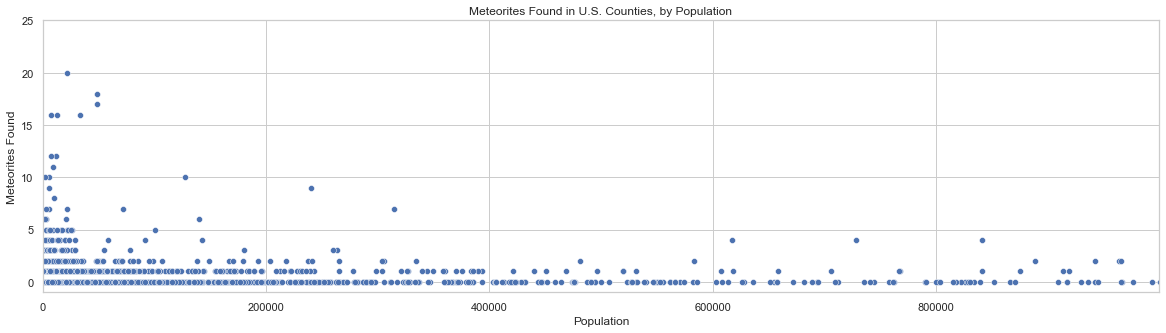

In [118]:
sns.set(rc={"figure.figsize":(20, 5)})
sns.set_style("whitegrid")
ax = sns.scatterplot(data=us_county_data, x='population', y='meteorite_count')
plt.title("Meteorites Found in U.S. Counties, by Population")
plt.ylabel("Meteorites Found")
plt.xlabel("Population")
plt.xlim(0, 999999)
plt.ylim(-1, 25)


Text(0.5, 0, 'Population')

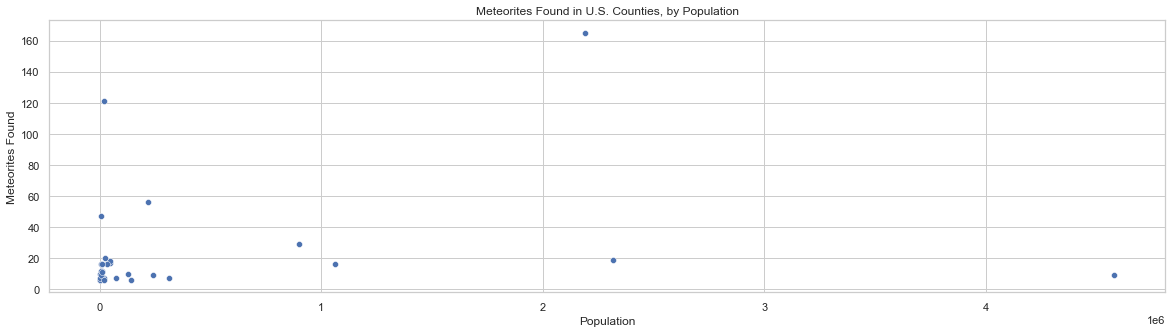

In [119]:
sns.set(rc={"figure.figsize":(20, 5)})
sns.set_style("whitegrid")
sns.scatterplot(data=us_county_data[us_county_data['meteorite_count'] > 5], x='population', y='meteorite_count')
plt.title("Meteorites Found in U.S. Counties, by Population")
plt.ylabel("Meteorites Found")
plt.xlabel("Population")
# plt.xlim(0, 999999)
# plt.ylim(0,25)

In [21]:
meteorite_counts = pd.DataFrame(meteorite_data.groupby(['country_code_3']).size().reset_index(name='meteorite_count'))
meteorite_counts.fillna(0)

world_meteorites = world.merge(meteorite_counts, how='left', left_on=['iso_a3'], right_on=['country_code_3'])
world_meteorites.head()


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,country_code_3,meteorite_count
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,10.0
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",ESH,24.0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,62.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,1662.0


<AxesSubplot:title={'center':'Countries with Number of Found Meteorites'}>

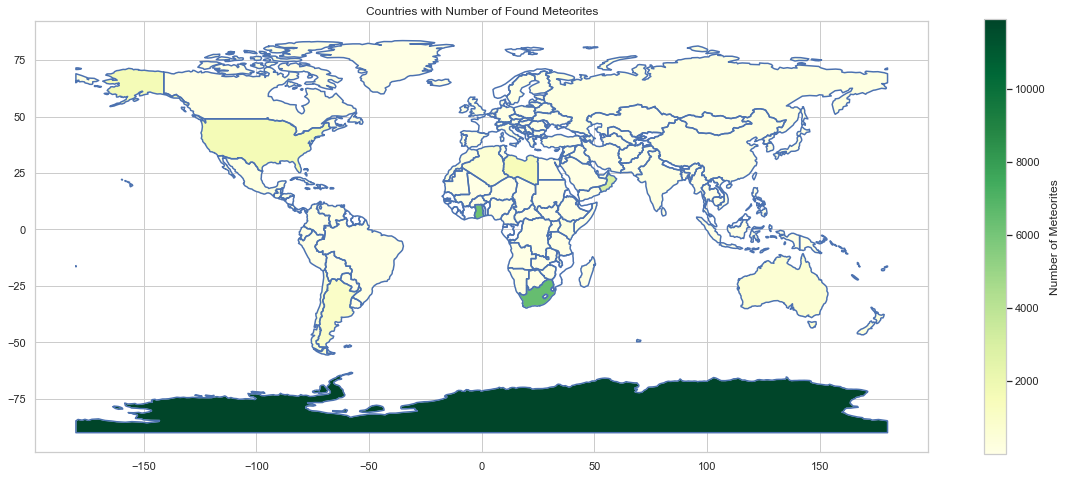

In [22]:
ax=world['geometry'].boundary.plot(figsize=(20,16))
ax.set_title("Countries with Number of Found Meteorites")

world_meteorites.plot( column="meteorite_count", ax=ax, cmap='YlGn', 
                     legend=True, legend_kwds={"label": "Number of Meteorites", "orientation":"vertical", 'shrink': 0.5})


Three hundred and forty-three active DCA are defined
to date, containing a total of 67,222 meteorites. The
average number of meteorites per DCA is 196 meteorites.
The median number of meteorites per DCA is four only,
reflecting a very uneven distribution of meteorites among
DCA. Only 37 DCA contain more than 100 meteorites,
and the 23 most populated DCA (most of them in
Antarctica) contain 90% of the total DCA meteorites. A
full list of all approved DCAs, with maps, can be found at
https://www.lpi.usra.edu/meteor/DenseAreas.php.

A meteorite can land anywhere on the Earth’s surface, even in its vast oceans. But there are some places where it is easier to spot a meteorite. Some of the best places to find meteorites are dry and barren lands. Such places do not have much vegetation or forest cover to conceal the meteorite, and they don’t have much rain which would either wash or wear away the meteorite.  The top meteorite hunting places include Antarctica, the desert in the northwest region of the African continent, and the American Southwest. Antarctica is particularly cool (pun intended) because it is a desert of snow and ice, and a dark, weird looking rock from space would be easy to spot.

***
### Afterthoughts
Also look at year Found meteorites in Antarctica.  
Also look at found meteorites referenced to climate zones.  
http://climateapi.scottpinkelman.com/

<AxesSubplot:xlabel='year', ylabel='count'>

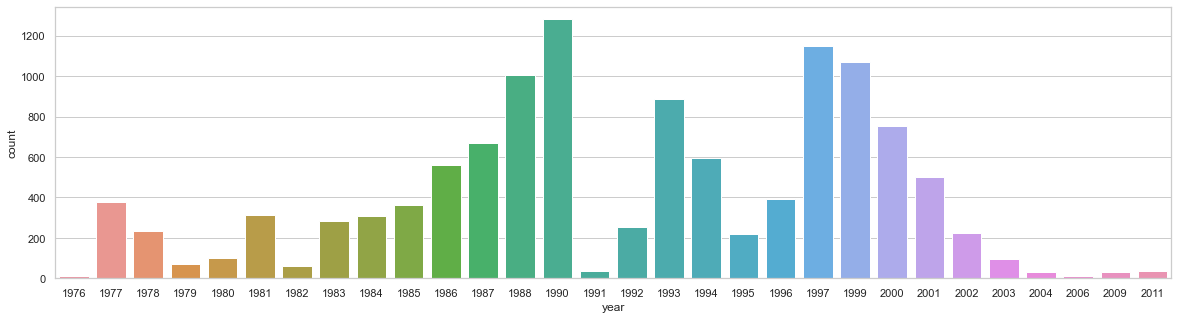

In [27]:
sns.countplot(x='year', data=meteorite_data[meteorite_data['country_name'] == 'Antarctica'])